<a href="https://colab.research.google.com/github/VishalkumarPandey7/plant-disease/blob/main/plant_disease(krishibot).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

--2025-12-16 05:54:06--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2025-12-16 05:54:06--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.66.232, 52.92.0.210, 52.218.91.96, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.66.232|:443... c

In [2]:
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  infl

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [4]:
!pip install split-folders

In [5]:
import splitfolders
splitfolders.ratio("/content/Plant_leave_diseases_dataset_with_augmentation" , output="dataset",seed=1337,ratio=(.8,.1,.1))


Copying files: 61486 files [00:11, 5312.56 files/s]


Data Processing

In [6]:
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 49179 files belonging to 39 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dir="/content/dataset/test"
test_dataset= tf.keras.utils.image_dataset_from_directory(test_dir,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


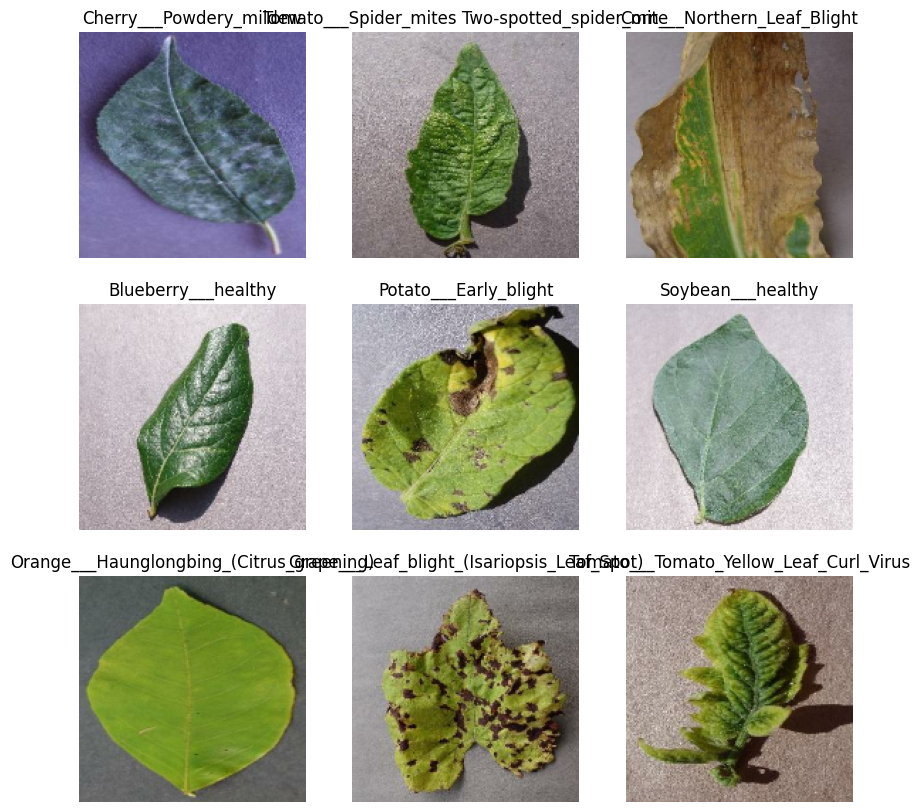

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
preprocess_input=tf.keras.applications.efficientnet.preprocess_input

base model

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model=tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE,
                                    include_top=False,
                                     weights='imagenet',

)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1792)


intensity /feature extractraction

In [13]:
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [15]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 39)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [18]:
initial_epochs = 7

loss0, accuracy0 = model.evaluate(validation_dataset)

192/192 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.0098 - loss: 3.7769


In [19]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/7
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 148s 70ms/step - accuracy: 0.7106 - loss: 1.1854 - val_accuracy: 0.9158 - val_loss: 0.3201
Epoch 2/7
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 88s 57ms/step - accuracy: 0.9042 - loss: 0.3414 - val_accuracy: 0.9353 - val_loss: 0.2263
Epoch 3/7
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 143s 58ms/step - accuracy: 0.9228 - loss: 0.2618 - val_accuracy: 0.9428 - val_loss: 0.1892
Epoch 4/7
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 142s 58ms/step - accuracy: 0.9324 - loss: 0.2250 - val_accuracy: 0.9461 - val_loss: 0.1672
Epoch 5/7
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 90s 58ms/step - accuracy: 0.9389 - loss: 0.2016 - val_accuracy: 0.9515 - val_loss: 0.1565
Epoch 6/7
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 89s 58ms/step - accuracy: 0.9409 - loss: 0.1880 - val_accuracy: 0.9552 - val_loss: 0.1408
Epoch 7/7
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 89s 58ms/step - accuracy: 0.9414 - loss: 0.1780 - val_accuracy: 0.9590 - val_loss: 0.1306


Fine tune

In [20]:
base_model.trainable = True

In [21]:

print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  475


In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [23]:
len(model.trainable_variables)

333

In [24]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 8/17
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 430s 205ms/step - accuracy: 0.8872 - loss: 0.4069 - val_accuracy: 0.9254 - val_loss: 0.3177
Epoch 9/17
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 235s 153ms/step - accuracy: 0.9636 - loss: 0.0932 - val_accuracy: 0.9537 - val_loss: 0.0818
Epoch 10/17
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 235s 153ms/step - accuracy: 0.9622 - loss: 0.0793 - val_accuracy: 0.9588 - val_loss: 0.2068
Epoch 11/17
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 235s 153ms/step - accuracy: 0.9715 - loss: 0.0636 - val_accuracy: 0.9497 - val_loss: 0.2188
Epoch 12/17
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 233s 152ms/step - accuracy: 0.9798 - loss: 0.0451 - val_accuracy: 0.9607 - val_loss: 0.0659
Epoch 13/17
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 235s 153ms/step - accuracy: 0.9696 - loss: 0.0511 - val_accuracy: 0.9466 - val_loss: 0.0554
Epoch 14/17
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 234s 152ms/step - accuracy: 0.9731 - loss: 0.0391 - val_accuracy: 0.9687 - val_loss: 0.0524
Epoch 15/17
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 235s 153ms/ste

In [25]:
acc = []
val_acc = []
loss = []
val_loss = []


In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [27]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

193/193 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.9309 - loss: 0.1287
Test accuracy : 0.9328793883323669


Predictions:
 [13 17 36 22  5 24 33  7 31 16 16 30 17 36 17 25 13 22 16 38 26 18 36 33
  5 19 14 11 25  5 16 20]
Labels:
 [13 17 36 22  5 24 33 20 31 16 16 30 17 36 17 25 13 22 16 38 26 18 36 33
  5 19 14 11 25  5 16 20]


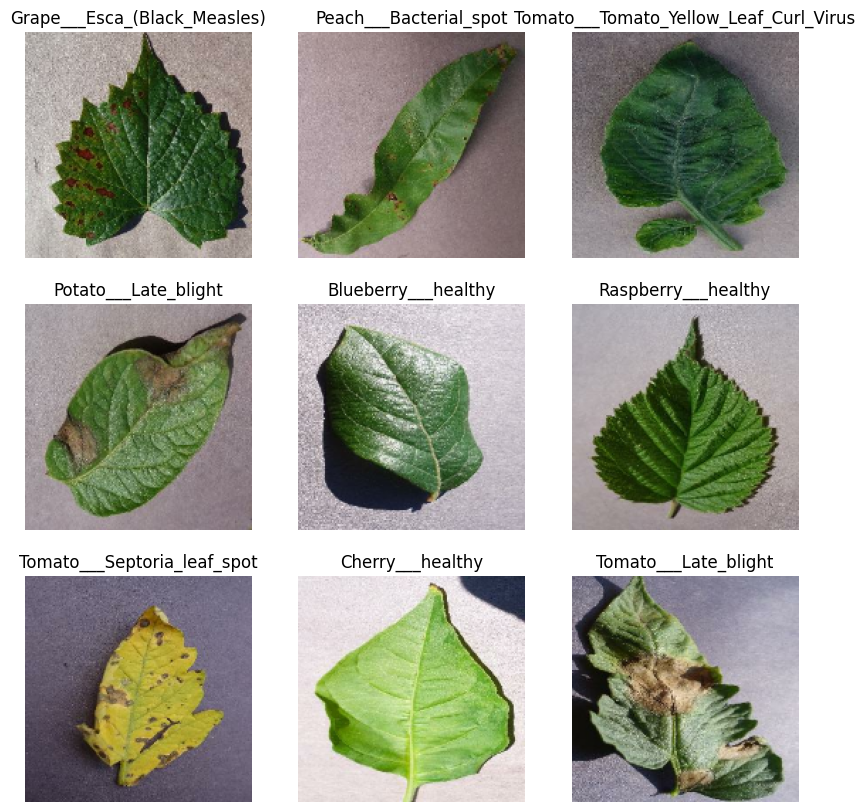

In [28]:

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions,axis=1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")